In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from post_processing import *
from utils_mini import *
from fast_macro_f1_func import *
import scipy as sp
import scipy.fftpack
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore") 

In [2]:
# chris clean dataset
df_train = pd.read_csv("../input/train_clean.csv")
df_test = pd.read_csv("../input/test_clean.csv")

df_train["local_time"] = df_train.time % 50
df_train.loc[df_train.local_time == 0.0000, "local_time"] = 50

df_test["local_time"] = df_test.time % 50
df_test.loc[df_test.local_time == 0.0000, "local_time"] = 50

df_test["mini_local_time"] = df_test.time % 10
df_test.loc[df_test.local_time == 0.0000, "mini_local_time"] = 10

BATCH_SIZE = 500000

# train
for batch_i in range(10):
    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
# test
for batch_i in range(4):
    df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_test.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_test.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_test.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_test.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
    
df_train = df_train.drop(df_train[(df_train.batch.isin([8]))].index)


In [3]:
# channel 0 - batch 1
channel_0_batch_1 = df_train[(df_train.batch == 1) & (df_train.open_channels == 0)]
channel_0_batch_1_threshold = channel_0_batch_1.signal.quantile(0.99999)
channel_0_batch_1.loc[channel_0_batch_1.signal > channel_0_batch_1_threshold, "signal"] = channel_0_batch_1_threshold
df_train.loc[(df_train.batch == 1) & (df_train.open_channels == 0), "signal"] = channel_0_batch_1.signal

In [4]:
# channel 0 - batch 2
channel_0_batch_2 = df_train[(df_train.batch == 2) & (df_train.open_channels == 0)]
channel_0_batch_2_threshold = channel_0_batch_2.signal.quantile(0.99999)
channel_0_batch_2.loc[channel_0_batch_2.signal > channel_0_batch_2_threshold, "signal"] = channel_0_batch_2_threshold
df_train.loc[(df_train.batch == 2) & (df_train.open_channels == 0), "signal"] = channel_0_batch_2.signal

In [5]:
df_train.loc[(df_train.batch.isin([5, 10])), "signal"] += 2.726
df_test.loc[(df_test.batch.isin([2])) & (df_test.mini_batch.isin([1, 3])),
            "signal"] += 2.726

In [6]:
# df_train = pd.read_pickle('../features/train_v2.pkl')
# df_test = pd.read_pickle('../features/test_v2.pkl')

sub = pd.read_csv("../input/sample_submission.csv")
sub['time'] = [format(sub.time.values[x], '.4f') for x in range(2000000)]
TARGET = "open_channels"

print(df_train.shape, df_test.shape, sub.shape)
df_train.head()

(4500000, 6) (2000000, 6) (2000000, 2)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [25]:

# <module 'scipy' from '/home/ww6p9/anaconda3/lib/python3.7/site-packages/scipy/__init__.py'>
fs = 10000

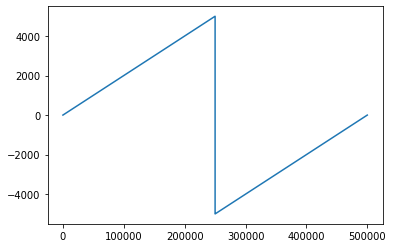

In [34]:
plt.plot(fftfreq[i])

In [60]:
df = df_train[(df_train.batch == 4) ]
print(df.shape)

# plt.plot(df.signal)

scale_back = [i * 1 for i in range(1, 5000 +1 )]
data_fft = np.fft.fft(df.signal)

# psd = np.abs(data_freq) ** 2
fftfreq = sp.fftpack.fftfreq(len(data_fft),1/fs)

# i = fftfreq > 0

# data_back_freq = 10 * np.log10(psd[i]) #* scale_back

# plt.plot(fftfreq[i], data_back_freq)

# plt.xscale('log')

(500000, 6)


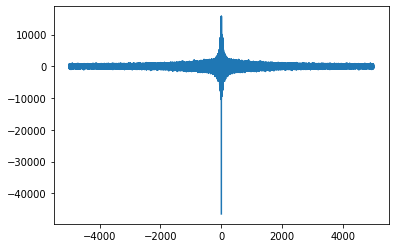

In [61]:
plt.plot(fftfreq, data_fft.real)

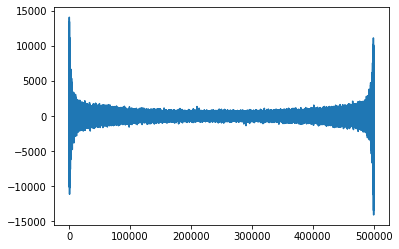

In [59]:
plt.plot(data_fft.imag)

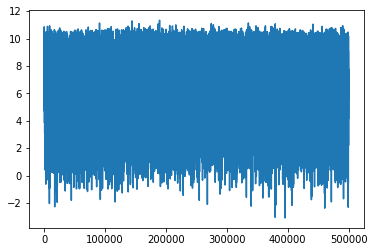

In [8]:
singal_back = np.fft.ifft(data_back_freq)
plt.plot(singal_back.real)


In [9]:
df["cover"] = singal_back.real

In [10]:
df.head()

,time,signal,open_channels,local_time,batch,mini_batch,cover
2000000,200.0001,9.8451,10,0.0001,5.0,1.0,9.8451
2000001,200.0002,9.4972,10,0.0002,5.0,1.0,9.4972
2000002,200.0003,9.6538,10,0.0003,5.0,1.0,9.6538
2000003,200.0004,10.0801,10,0.0004,5.0,1.0,10.0801
2000004,200.0005,10.1454,10,0.0005,5.0,1.0,10.1454


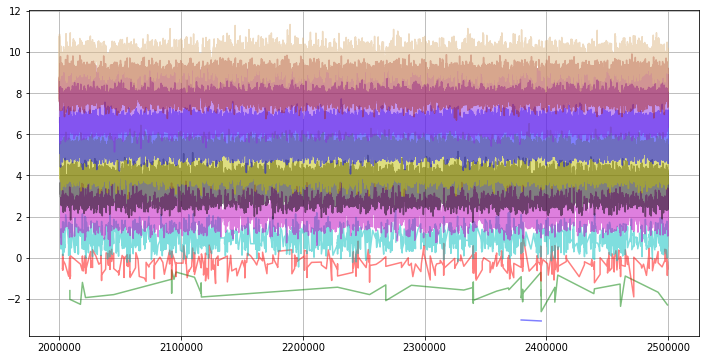

In [11]:
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]

fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df[df.open_channels == channel_i].signal,
#              ".",
             color=color_list[channel_i],
             alpha=0.5)

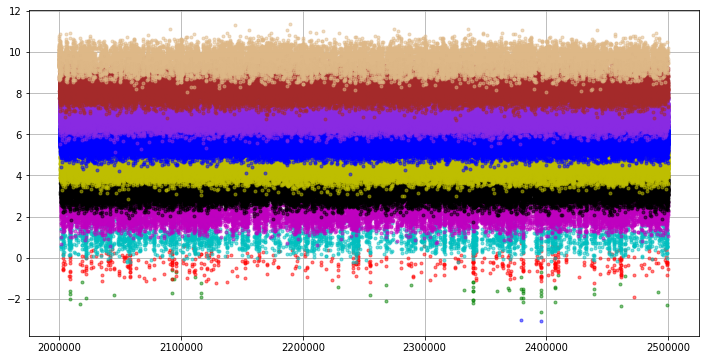

In [12]:
# oof plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df[df.open_channels == channel_i].cover,
             ".",
             color=color_list[channel_i],
             alpha=0.5)